In [1]:
import numpy as np
import scipy.linalg
from numba import njit, prange
import knv as kNV
import qutip as qu

import matplotlib.pyplot as plt

In [2]:
import sys
import os
sys.path.append(os.path.abspath(r'C:/Users/koko/GIT/parament/src/python/pyparament/'))
os.environ['PARAMENT_LIB_DIR'] = os.path.abspath(r'C:/Users/koko/GIT/parament/build')
import parament

In [3]:
dtype_base = np.complex128

ox = np.array([[0,1],[1,0]],dtype=dtype_base)
oy = np.array([[0,-1j],[1j,0]],dtype=dtype_base)
oz = np.array([[1,0],[0,-1]],dtype=dtype_base)
oe = np.array([[1,0],[0,1]],dtype=dtype_base)

w0  = 1.0
w1  = 0.1  + np.finfo(np.float64).eps
wrf = 1.0
TSTOP = 6  - np.finfo(np.float64).eps

H0 = w0/2 * qu.sigmaz()
H1 = w1/2 * qu.sigmax()
H2 = w1/2 * qu.sigmay()

In [4]:
def Uexact(t):
    dw = w0 - wrf
    #print(dw)
    gen = np.sqrt(w1**2+dw**2)
    explabM = np.exp(-0.5j*t*wrf)
    explabP = np.exp(0.5j*t*wrf)
    x = 0.5*gen*t
    fact1 = dw/gen
    fact2 = w1/gen
    M1 = explabP*(np.cos(x) + 1j*fact1 * np.sin(x))
    M2 = explabP*(1j*fact2*np.sin(x))
    M3 = explabM*(1j*fact2*np.sin(x))
    M4 = explabM*(np.cos(x) - 1j*fact1 * np.sin(x))  
    #return qu.Qobj(np.array([[M1,M2],[M3,M4]])).tidyup()
    return np.array([[M1,M2],[M3,M4]])
    

In [5]:
def compare(pts,prec,magnus,quad):
    print(pts)
    GPURunner = parament.Parament(precision=prec)
    GPURunner.set_hamiltonian(np.array(H0),np.array(H1),np.array(H2),use_magnus=magnus,quadrature_mode=quad)
    t = np.linspace(0,TSTOP,pts)
    dt = t[1]-t[0]
    carr1 = np.cos(wrf*t)
    carr2 = np.sin(wrf*t)

    outGPU = GPURunner.equiprop(dt,carr1,carr2)
    #u,s,v = np.linalg.svd(outGPU)
    #outGPU = u @ v
    print(outGPU)
    GPURunner.destroy()
   
    propagator_exact = Uexact(TSTOP).conj()
    print(propagator_exact)
    Ndiff = outGPU - propagator_exact
    norm_diff = np.linalg.norm(Ndiff)
    #expect1 = qu.expect(qu.sigmax(),outGPU*qu.basis(2,0))
    #expect2 = qu.expect(qu.sigmax(),propagator_exact*qu.basis(2,0))
    #norm_diff = np.abs(expect1-expect2)
    print(norm_diff)
    print("------------")
    return norm_diff

In [6]:
steps = np.logspace(0.5,4.5,dtype=int) +2
for i in range(len(steps)):
    if steps[i] % 2 == 0:
        steps[i] = steps[i]+1

In [7]:
y1 = qu.serial_map(compare,steps,task_args=('fp32',True,'simpson'))
y2 = qu.serial_map(compare,steps,task_args=('fp32',False,'midpoint'))
y3 = qu.serial_map(compare,steps,task_args=('fp32',False,'simpson'))



5
1.5
[[-0.964969  -0.11840416j -0.03303998+0.23178369j]
 [ 0.03303996+0.23178369j -0.96496904+0.11840416j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
0.09388203816410738
------------
5
1.5
[[-0.964969  -0.11840416j -0.03303998+0.23178369j]
 [ 0.03303996+0.23178369j -0.96496904+0.11840416j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
0.09388203816410738
------------
7
1.0
[[-0.95099515-0.12972668j -0.03960902+0.27786732j]
 [ 0.03960902+0.27786732j -0.95099515+0.12972663j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
0.023387924177021627
------------
7
1.0
[[-0.95099515-0.12972668j -0.03960902+0.27786732j]
 [ 0.03960902+0.27786732j -0.95099515+0.12972663j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
0.023387924177021627
------------
9
0.75
[[-0.947597

 [ 0.04170353+0.29256067j -0.94577837+0.13481787j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
7.075839495275314e-06
------------
891
0.006741573033707865
[[-0.9457333 -0.1348107j  -0.0417015 +0.29254678j]
 [ 0.04170154+0.29254666j -0.94573   +0.13481042j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
6.74221113355991e-05
------------
1075
0.00558659217877095
[[-0.94578207-0.13481787j -0.04170397+0.29256427j]
 [ 0.04170406+0.2925643j  -0.94578993+0.13481931j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
1.5582393313953832e-05
------------
1297
0.004629629629629629
[[-0.9457989 -0.13482098j -0.0417047 +0.29256848j]
 [ 0.04170455+0.29256845j -0.94579685+0.13482022j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
3.243896490416378e-05
------------
1565
0.0038

 [ 0.04170756+0.29258943j -0.9458714 +0.13483064j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
0.0001299379942044822
------------
8485
0.0007072135785007072
[[-0.9458986 -0.13483505j -0.04170887+0.29259774j]
 [ 0.04170877+0.292598j   -0.94588053+0.13483196j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
0.00017038797402727345
------------
10239
0.000586051963274077
[[-0.94574624-0.13481258j -0.04170264+0.29255503j]
 [ 0.04170278+0.29255503j -0.94575566+0.13481446j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
3.8009957302650394e-05
------------
12357
0.00048559404337973454
[[-0.94578856-0.13481922j -0.04170382+0.2925624j ]
 [ 0.04170365+0.2925622j  -0.94576037+0.13481466j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
2.031858452794589e-05
------------
14

In [8]:
def fun(x,alpha,konst):
    return -alpha*x+konst

(5e-08, 0.1)

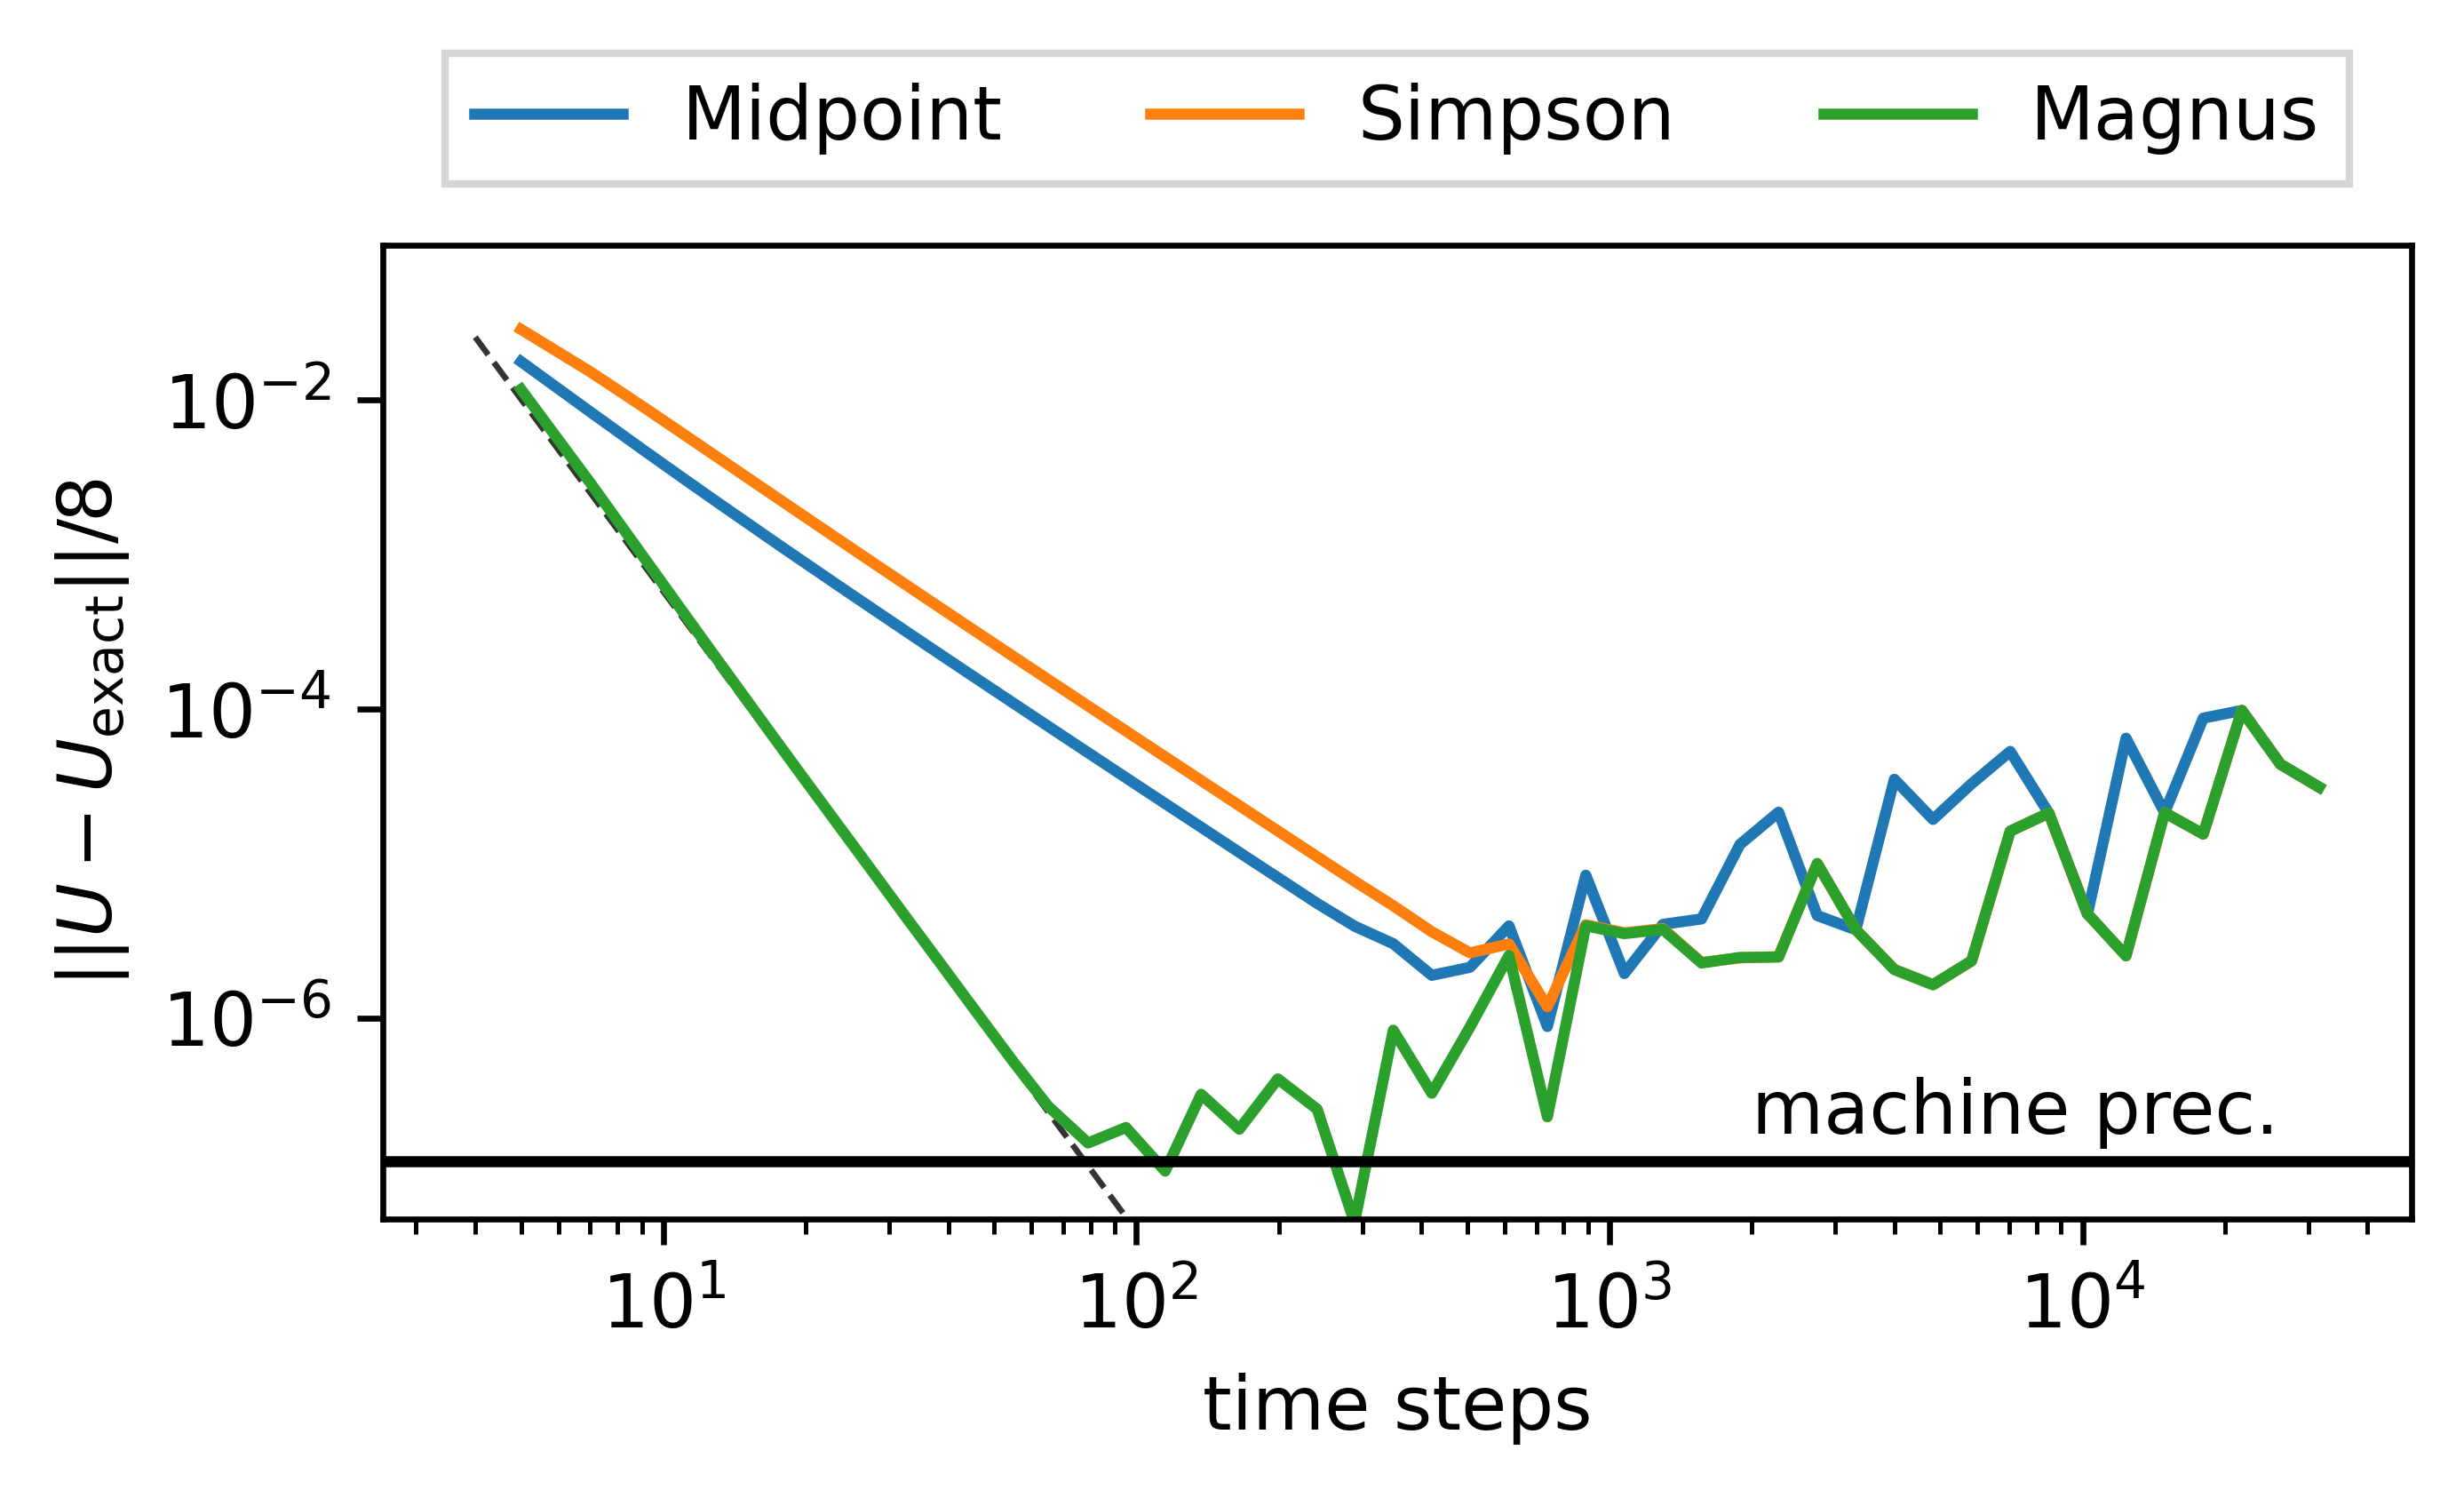

In [13]:
golden_ratio = 1.61803398875
inch = 0.0393701
size = 120
plt.figure(figsize=(size*inch,size*inch/golden_ratio),dpi=600)

#plt.loglog([steps[0],steps[11]],[y1[0]/8,y1[11]/8])
x = np.logspace(np.log10(4),np.log10(1e2),1000)
alpha = 4.13931679
konst = 0.9
y = 10**fun(np.log10(x),alpha,konst)
plt.loglog(x,y,c='k',ls='--',alpha=0.8,lw='0.8')

plt.loglog(steps,np.array(y2)/8,label='Midpoint')
plt.loglog(steps,np.array(y3)/8,label='Simpson')
plt.loglog(steps,np.array(y1)/8,label='Magnus')
plt.ylabel('$||U-U_\mathrm{exact}||/8$')
plt.xlabel('time steps')
plt.axhline(2**-23,c='k')
plt.text(2e3,1.5*2**-23,'machine prec.')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.025),
          ncol=3, fancybox=False, shadow=False)
plt.tight_layout()
#plt.xlim([9,4e4])
plt.ylim([5e-8,1e-1])
#plt.savefig('fp32_convergence_update.svg')

In [17]:
steps = np.logspace(0.7,6.1,101,dtype=int)
for i in range(len(steps)):
    if steps[i] % 2 == 0:
        steps[i] = steps[i]+1

In [11]:
steps = np.array([     13,      15,      21,      25,      33,      41,      51,
            65,      83,     105,     131,     167,     211,     267,
           337,     427,     541,     683,     865,    1093,    1383,
          1749,    2217,    2799,    3539,    4477,    5663,    7163,
          9061,   11459,   14495,   18335,   23191,   29333,   37101,
         46927,   59357,   75077,   94963,  120113,  151927,  192165,
        243061,  307437,  388863,  491855,  622125,  786897,  995311,
       1258925])+2

In [18]:
z1 = qu.serial_map(compare,steps,task_args=('fp64',True,'simpson'))
z2 = qu.serial_map(compare,steps,task_args=('fp64',False,'midpoint'))
z3 = qu.serial_map(compare,steps,task_args=('fp64',False,'simpson'))



5
[[-0.96496902-0.11840395j -0.03303996+0.23178366j]
 [ 0.03303996+0.23178366j -0.96496902+0.11840395j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
0.09388216039115813
------------
5
[[-0.96496902-0.11840395j -0.03303996+0.23178366j]
 [ 0.03303996+0.23178366j -0.96496902+0.11840395j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
0.09388216039115813
------------
7
[[-0.95099521-0.12972661j -0.03960902+0.27786731j]
 [ 0.03960902+0.27786731j -0.95099521+0.12972661j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
0.023387976764573312
------------
7
[[-0.95099521-0.12972661j -0.03960902+0.27786731j]
 [ 0.03960902+0.27786731j -0.95099521+0.12972661j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
0.023387976764573312
------------
9
[[-0.94759751-0.13295254j -0.040

[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
1.5031636932026647e-12
------------
2511
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
9.156773612215002e-13
------------
2845
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
5.623163915220142e-13
------------
3221
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
4.1950580283059226e-13
------------
3647
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-

[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
6.384420374311143e-12
------------
194985
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
9.018641039576877e-12
------------
220801
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
2.2502505045303837e-11
------------
250035
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
9.771829738756724e-12
------------
283139
[[-0.94

[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
4.0454428788642075e-07
------------
2845
[[-0.94577602-0.13481709j -0.04170378+0.29256258j]
 [ 0.04170378+0.29256258j -0.94577602+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
3.1510432206562135e-07
------------
3221
[[-0.94577601-0.13481709j -0.04170379+0.29256262j]
 [ 0.04170379+0.29256262j -0.94577601+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
2.45811287834198e-07
------------
3647
[[-0.945776 -0.13481709j -0.0417038+0.29256266j]
 [ 0.0417038+0.29256266j -0.945776 +0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
1.9172566535828147e-07
------------
4131
[[-0.94577599-0.13481709j -0.0417038 +0.29256269j]
 [ 0.0417038 +0.29256269j -0.94577599+0.13481709j]]
[[-0.94577596-0.13

[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
8.609958836975797e-11
------------
194985
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
6.741454660282791e-11
------------
220801
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
5.4188257620845835e-11
------------
250035
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
4.240610690317689e-11
------------
283139
[[-0.94

[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
2.3397277873702276e-07
------------
5297
[[-0.945776 -0.13481709j -0.0417038+0.29256267j]
 [ 0.0417038+0.29256267j -0.945776 +0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
1.8239730149046844e-07
------------
5997
[[-0.94577599-0.13481709j -0.0417038 +0.29256269j]
 [ 0.0417038 +0.29256269j -0.94577599+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
1.4229548881309267e-07
------------
6793
[[-0.94577598-0.13481709j -0.0417038 +0.29256271j]
 [ 0.0417038 +0.29256271j -0.94577598+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
1.1089680667273563e-07
------------
7691
[[-0.94577597-0.13481709j -0.04170381+0.29256273j]
 [ 0.04170381+0.29256273j -0.94577597+0.13481709j]]
[[-0.94577596-0.

[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
3.883226482814979e-11
------------
411149
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
3.566558976302512e-11
------------
465587
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
3.7664375250402623e-11
------------
527229
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
[[-0.94577596-0.13481709j -0.04170381+0.29256279j]
 [ 0.04170381+0.29256279j -0.94577596+0.13481709j]]
3.992847579916059e-11
------------
597035
[[-0.94

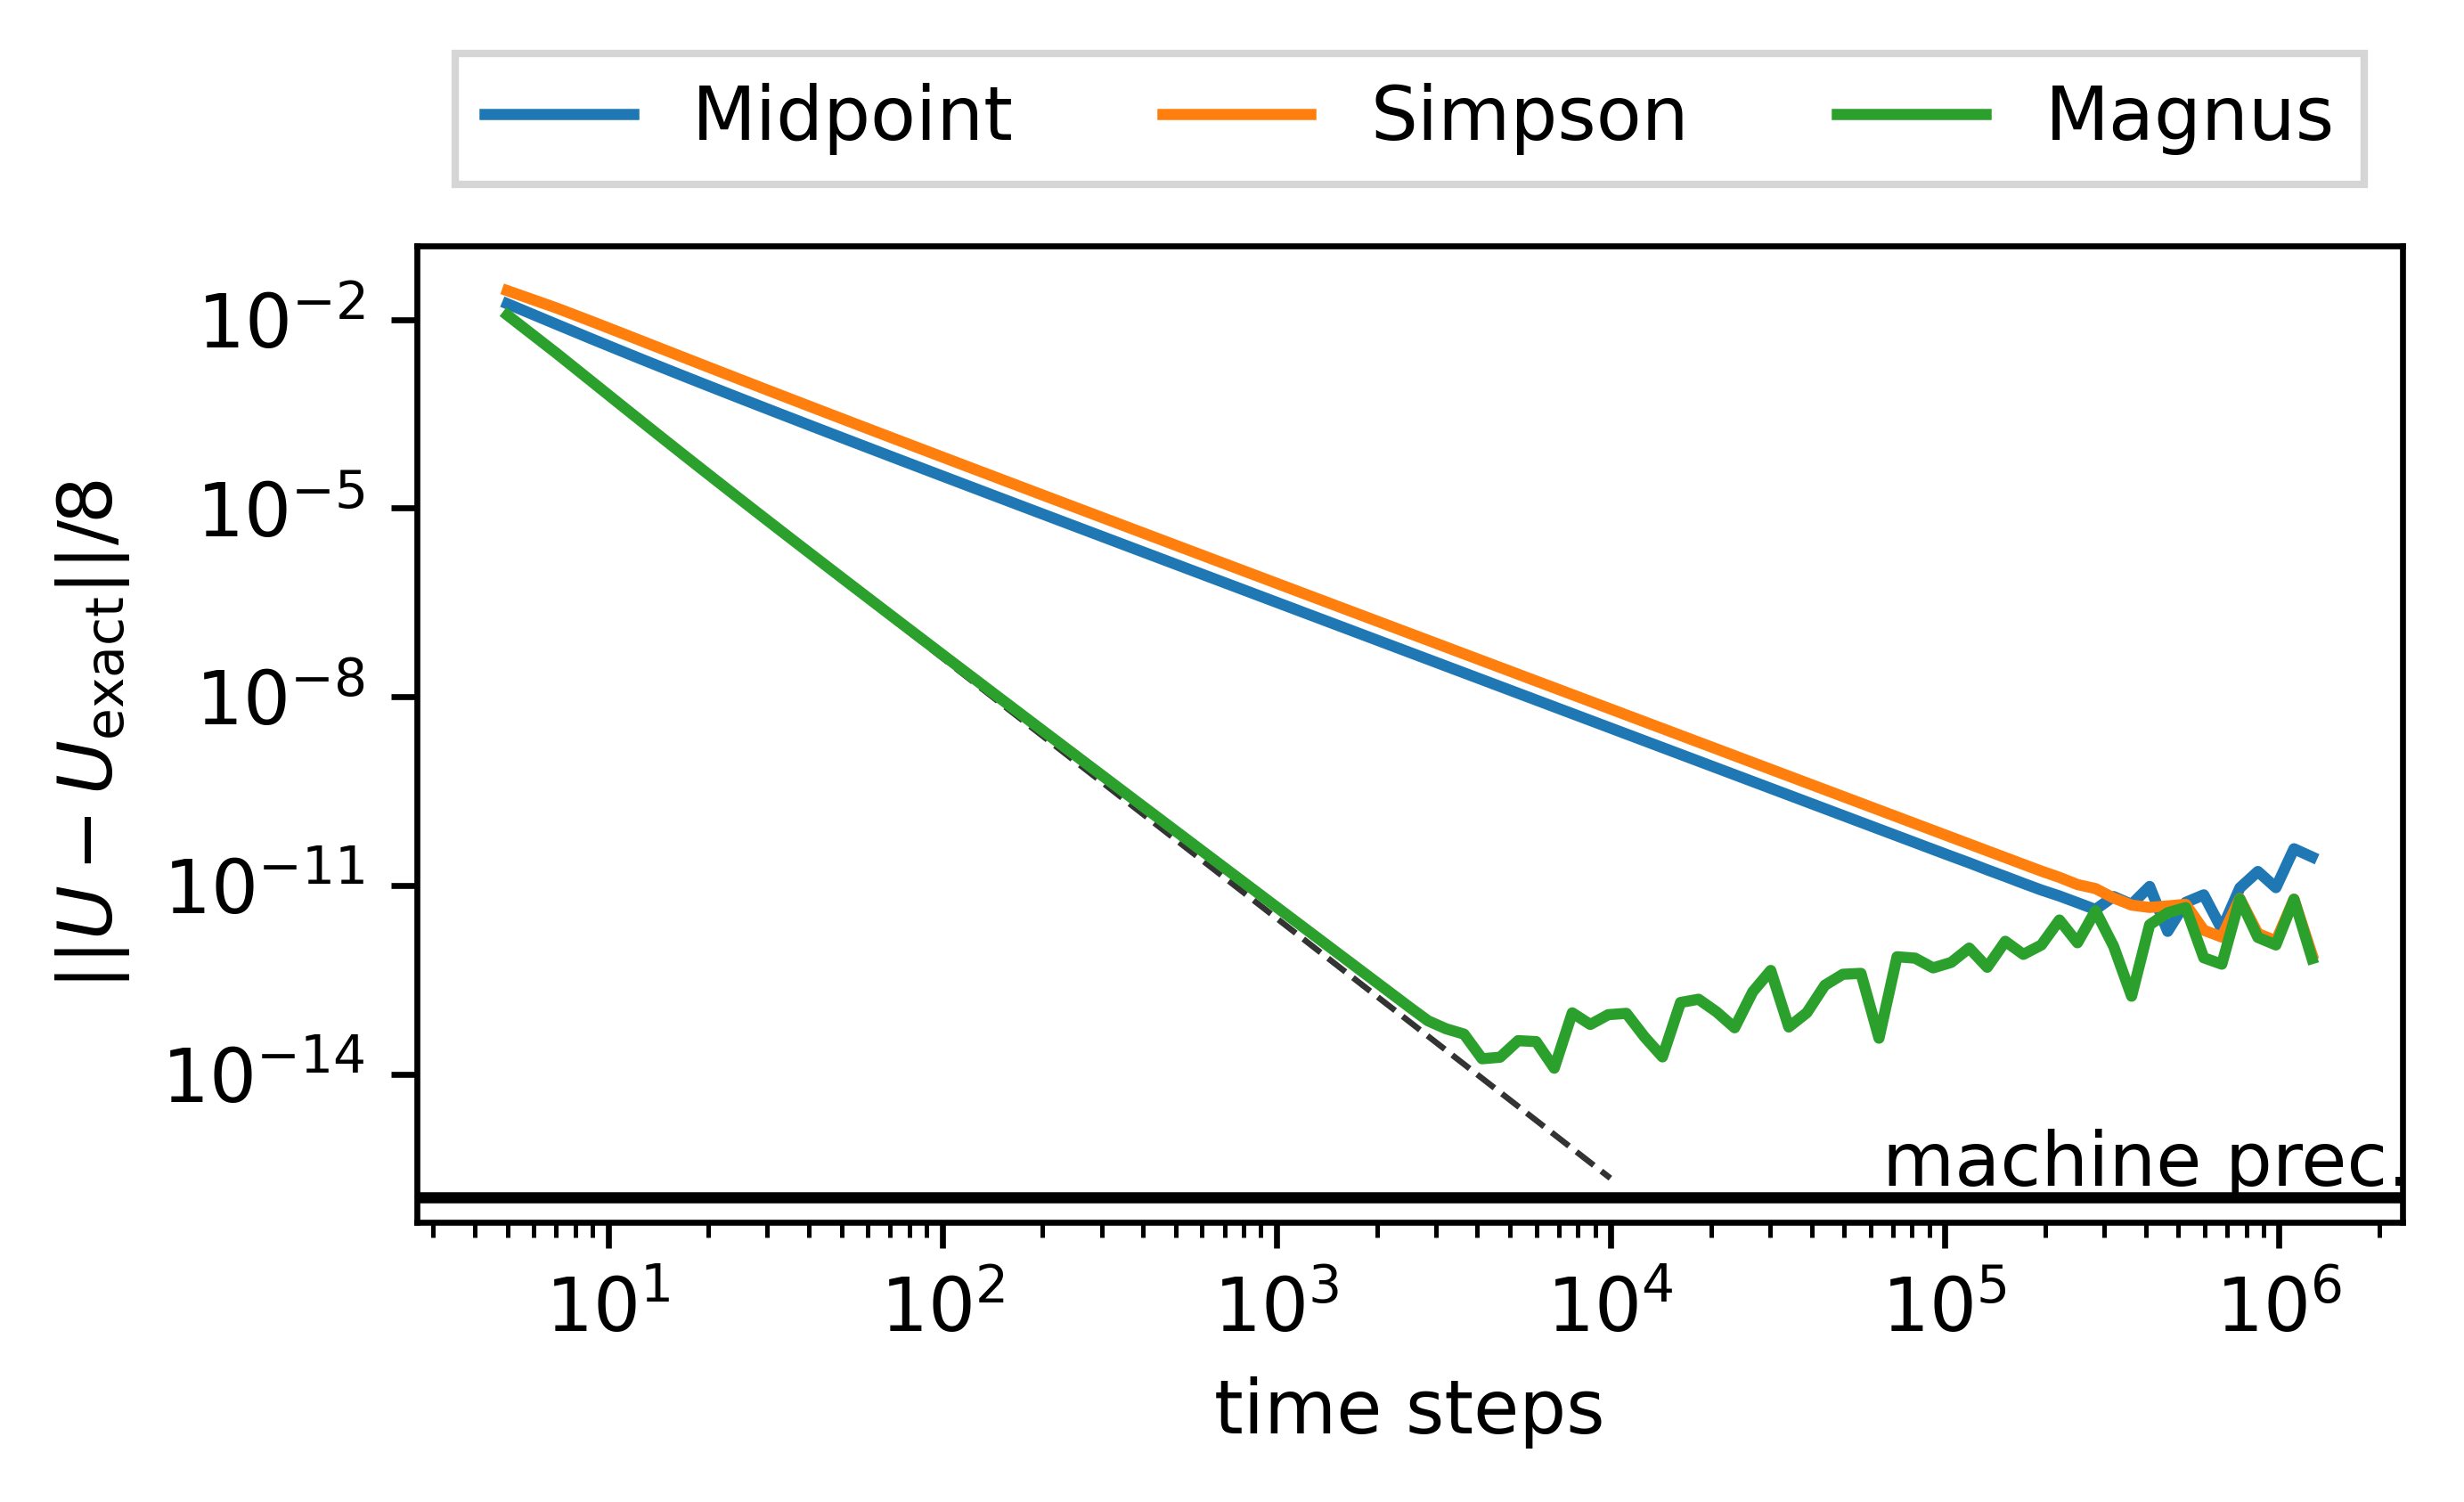

In [20]:
golden_ratio = 1.61803398875
inch = 0.0393701
size = 120
plt.figure(figsize=(size*inch,size*inch/golden_ratio),dpi=600)
#plt.loglog([steps[0],steps[11]],[y1[0]/8,y1[11]/8])
x = np.logspace(np.log10(10),np.log10(1e4),1000)
alpha = 4.13931679
konst = 0.9
y = 10**fun(np.log10(x),alpha,konst)
plt.loglog(x,y,c='k',ls='--',alpha=0.8,lw='0.8')
plt.loglog(steps,np.array(z2)/8,label='Midpoint')
plt.loglog(steps,np.array(z3)/8,label='Simpson')
plt.loglog(steps,np.array(z1)/8,label='Magnus')
#plt.loglog([2e1,5e3],[1.5e-4,2.5e-14])
plt.ylabel('$||U-U_\mathrm{exact}||/8$')
plt.xlabel('time steps')
plt.axhline(2**-53,c='k')
plt.text(6.5e4,1.5*2**-53,'machine prec.')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.025),
          ncol=3, fancybox=False, shadow=False)
plt.tight_layout()
plt.savefig('fp64_convergence_update.svg')

In [20]:
np.array(z1)[22]/8

0.0

In [25]:
np.log10(5589165)

6.747346930788167

In [26]:
for i in range(len(steps)):
    print(steps[i],z1[i])

15 0.0009154991152457864
17 0.0005408390031501401
23 0.0001531260227127476
27 7.879553235710932e-05
35 2.7052604742879188e-05
43 1.164031669608371e-05
53 4.960295706474981e-06
67 1.9130817105875235e-06
85 7.29505812015536e-07
107 2.877925453743758e-07
133 1.1969495055915966e-07
169 4.5619769281159196e-08
213 1.7993611127427363e-08
269 7.046855721843218e-09
339 2.7847437702369025e-09
429 1.0842020057305853e-09
543 4.210658829124792e-10
685 1.6600846881200006e-10
867 6.446057132786974e-11
1095 2.526250901182696e-11
1385 9.889726886970955e-12
1751 3.379467008982784e-12
2219 0.0
2801 0.0
3541 0.0
4479 0.0
5665 0.0
7165 0.0
9063 0.0
11461 0.0
14497 0.0
18337 1.3842260671026452e-12
23193 0.0
29335 1.4066525722000733e-12
37103 0.0
46929 1.3248291352851993e-12
59359 2.733588461861776e-12
75079 3.1419925822757222e-12
94965 1.634359314550693e-12
120115 0.0
151929 2.1852285485351216e-12
192167 1.3717820613817457e-11
243063 3.2002178684820137e-12
307439 1.9141770196997773e-11
388865 1.840754620007

In [25]:
H2

array([[0.+0.j  , 0.-0.05j],
       [0.+0.05j, 0.+0.j  ]])

In [26]:
def set_hamiltonian(*H1):
    if len(H1) == 0:
        raise ValueError('provide at least 1 control amplitude')
    else:
        H1 = np.atleast_2d(H1)
    amps = np.shape(H1)
    if len(amps) > 2:
        amps = amps[0]
        H1 = np.swapaxes(H1, 0, 2)
    else:
        amps = 1
    H1 = np.swapaxes(H1, 0, 1)
    print(np.shape(H1))
    print(np.ravel(H1,order='F'))

In [55]:
set_hamiltonian(np.ones((2,4)),np.ones((2,4)),np.ones((2,4)))

(2, 4, 3)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [78]:
def store(pts,prec,magnus,quad):
    print(pts)
    GPURunner = parament.Parament(precision=prec)
    GPURunner.set_hamiltonian(np.array(H0),np.array(H1),np.array(H2),use_magnus=magnus,quadrature_mode=quad)
    t = np.linspace(0,TSTOP,pts)
    dt = t[1]-t[0]
    carr1 = np.cos(wrf*t)
    carr2 = np.sin(wrf*t)

    outGPU = GPURunner.equiprop(dt,carr1,carr2)
    #u,s,v = np.linalg.svd(outGPU)
    #outGPU = u @ v
    print(outGPU)
    GPURunner.destroy()
    return outGPU
   
    

In [79]:
y1 = qu.serial_map(store,steps,task_args=('fp64',True,'simpson'))
y2 = qu.serial_map(store,steps,task_args=('fp64',False,'midpoint'))
y3 = qu.serial_map(store,steps,task_args=('fp64',False,'simpson'))

13
[[ 0.25548175+0.8460522j   0.44867487-0.13272382j]
 [-0.44867487-0.13272382j  0.25548175-0.8460522j ]]
15
[[ 0.25265712+0.84404529j  0.45359442-0.13417909j]
 [-0.45359442-0.13417909j  0.25265712-0.84404529j]]
21
[[ 0.24989604+0.84216061j  0.45819874-0.1355411j ]
 [-0.45819874-0.1355411j   0.24989604-0.84216061j]]
25
[[ 0.24940905+0.84183981j  0.45898413-0.13577343j]
 [-0.45898413-0.13577343j  0.24940905-0.84183981j]]
33
[[ 0.24908939+0.8416325j   0.45949307-0.13592399j]
 [-0.45949307-0.13592399j  0.24908939-0.8416325j ]]
41
[[ 0.24899999+0.84157523j  0.45963405-0.13596569j]
 [-0.45963405-0.13596569j  0.24899999-0.84157523j]]
51
[[ 0.24896295+0.84155165j  0.4596922 -0.13598289j]
 [-0.4596922 -0.13598289j  0.24896295-0.84155165j]]
65
[[ 0.2489467 +0.84154135j  0.45971763-0.13599041j]
 [-0.45971763-0.13599041j  0.2489467 -0.84154135j]]
83
[[ 0.2489406 +0.8415375j   0.45972715-0.13599323j]
 [-0.45972715-0.13599323j  0.2489406 -0.8415375j ]]
105
[[ 0.24893839+0.8415361j   0.45973061-0.13

9061
[[ 0.24893701+0.84153527j  0.4597327 -0.13599487j]
 [-0.4597327 -0.13599487j  0.24893701-0.84153527j]]
11459
[[ 0.248937  +0.84153525j  0.45973273-0.13599488j]
 [-0.45973273-0.13599488j  0.248937  -0.84153525j]]
14495
[[ 0.24893699+0.84153524j  0.45973275-0.13599489j]
 [-0.45973275-0.13599489j  0.24893699-0.84153524j]]
18335
[[ 0.24893699+0.84153523j  0.45973277-0.13599489j]
 [-0.45973277-0.13599489j  0.24893699-0.84153523j]]
23191
[[ 0.24893699+0.84153523j  0.45973277-0.13599489j]
 [-0.45973277-0.13599489j  0.24893699-0.84153523j]]
29333
[[ 0.24893699+0.84153523j  0.45973278-0.13599489j]
 [-0.45973278-0.13599489j  0.24893699-0.84153523j]]
37101
[[ 0.24893699+0.84153522j  0.45973278-0.13599489j]
 [-0.45973278-0.13599489j  0.24893699-0.84153522j]]
46927
[[ 0.24893699+0.84153522j  0.45973278-0.1359949j ]
 [-0.45973278-0.1359949j   0.24893699-0.84153522j]]
59357
[[ 0.24893699+0.84153522j  0.45973278-0.1359949j ]
 [-0.45973278-0.1359949j   0.24893699-0.84153522j]]
75077
[[ 0.24893699+

In [74]:
 propagator_exact = np.array(Uexact(TSTOP).conj())

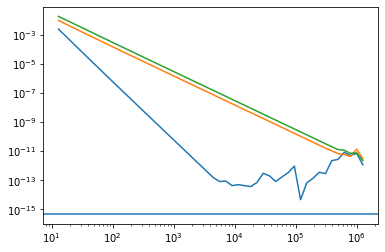

In [81]:
plt.loglog(steps,np.linalg.norm(y1 - propagator_exact,axis=(1,2))/8)
plt.loglog(steps,np.linalg.norm(y2 - propagator_exact,axis=(1,2))/8)
plt.loglog(steps,np.linalg.norm(y3 - propagator_exact,axis=(1,2))/8)
plt.axhline(np.finfo(np.float64).eps*2)

In [67]:
np.shape(y1)

(50, 2, 2)